In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

In [3]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         horizontal_flip = True,
                                         zoom_range = 0.2)

val_datagen = image.ImageDataGenerator(rescale=1./255)

In [4]:
training_data = train_datagen.flow_from_directory('Train',
                                                  target_size=(224,224),
                                                  class_mode='binary',
                                                  batch_size=32)

val_data = val_datagen.flow_from_directory('Val',
                                           target_size=(224,224),
                                           class_mode='binary',
                                           batch_size=32)

Found 282 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [5]:
training_data.class_indices

{'COVID': 0, 'NORMAL': 1}

In [6]:
e = 20
hist = model.fit(training_data,
                    steps_per_epoch=8,
                    epochs = e,
                    validation_data = val_data,
                    validation_steps = 2)
model.save('../models/cod.h5')

Epoch 1/20
8/8 [==============================] - 94s 11s/step - loss: 2.0889 - accuracy: 0.5320 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 64s 8s/step - loss: 0.6294 - accuracy: 0.6440 - val_loss: 0.6017 - val_accuracy: 0.6719
Epoch 3/20
8/8 [==============================] - 89s 11s/step - loss: 0.5523 - accuracy: 0.7560 - val_loss: 0.5045 - val_accuracy: 0.8906
Epoch 4/20
8/8 [==============================] - 69s 9s/step - loss: 0.4251 - accuracy: 0.8200 - val_loss: 0.3564 - val_accuracy: 0.9375
Epoch 5/20
8/8 [==============================] - 70s 8s/step - loss: 0.3330 - accuracy: 0.8920 - val_loss: 0.3327 - val_accuracy: 0.9062
Epoch 6/20
8/8 [==============================] - 67s 8s/step - loss: 0.2820 - accuracy: 0.8840 - val_loss: 0.3586 - val_accuracy: 0.9531
Epoch 7/20
8/8 [==============================] - 63s 8s/step - loss: 0.2496 - accuracy: 0.8960 - val_loss: 0.2081 - val_accuracy: 0.9531
Epoch 8/20
8/8 [================

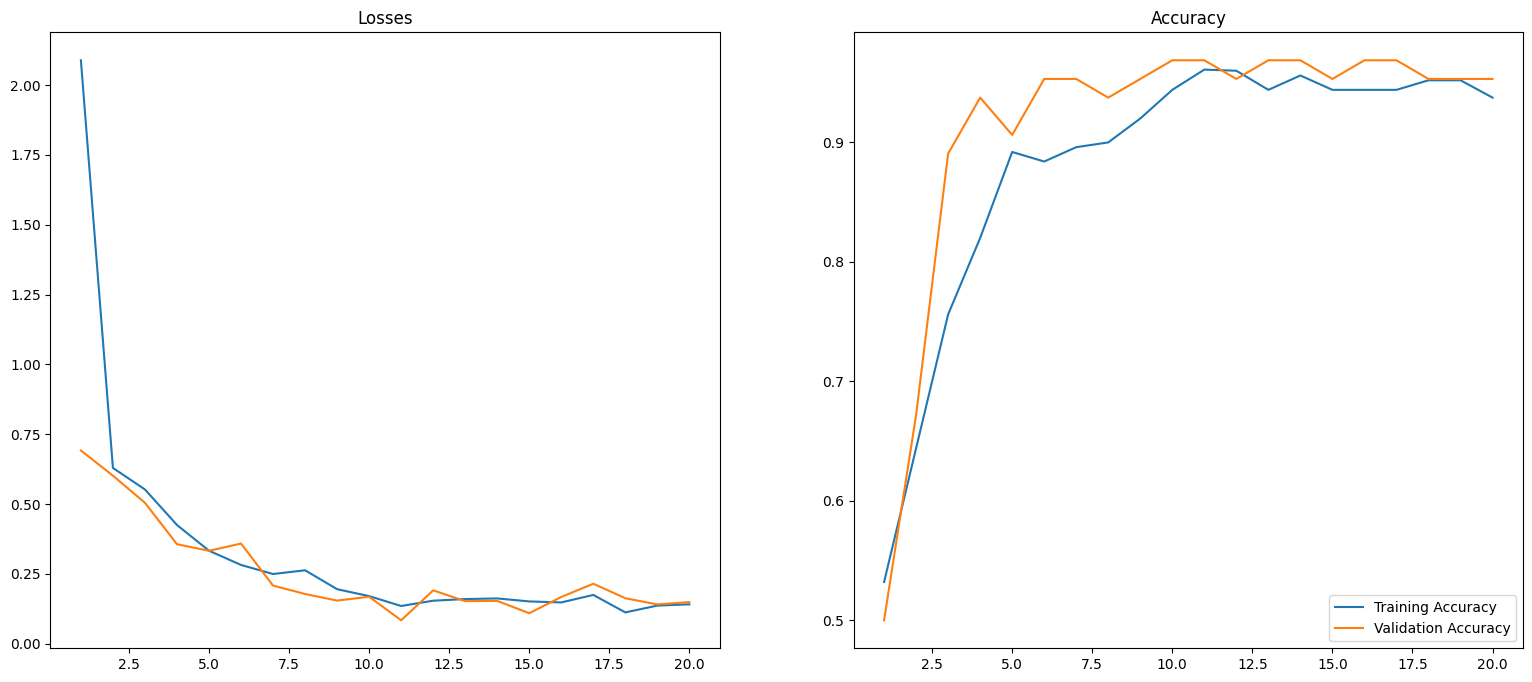

In [7]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1,e+1)

plt.figure(figsize=(19,8))
plt.subplot(121)
plt.plot(epochs,train_loss,label='Training loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Losses')

plt.subplot(122)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.title('Accuracy')

plt.legend()

In [8]:
model.evaluate_generator(training_data)

C:\Users\hp\AppData\Local\Temp\ipykernel_27652\4125820930.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(training_data)


[0.13798542320728302, 0.9680851101875305]

In [9]:
model.evaluate_generator(val_data)

C:\Users\hp\AppData\Local\Temp\ipykernel_27652\3807241483.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_data)


[0.14214728772640228, 0.949999988079071]

### Testing

In [10]:
import cv2
import os
import seaborn as sns
from tensorflow.keras.models import load_model

TP = 0
TN = 0
FP = 0
FN = 0

model = load_model('../models/covid.h5')

covid_images = os.listdir('Test/COVID')
normal_images = os.listdir('Test/NORMAL')

for i in covid_images:
    img = cv2.imread('Test/COVID/'+i)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    img = img/255.0
    pred = model.predict(img)
    if pred<0.5:
    TP+=1
    else:
    FN+=1

for i in normal_images:
    img = cv2.imread('Test/NORMAL/'+i)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    img = img/255.0
    pred = model.predict(img)
    if pred>0.5:
    TN+=1
    else:
    FP+=1
  
sns.heatmap([[TP,FP],[FN,TN]],annot=True)

IndentationError: expected an indented block (4043367290.py, line 23)